In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict, List
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AnyMessage
import operator

In [3]:
model = AzureChatOpenAI(openai_api_version=os.environ.get("AZURE_OPENAI_VERSION", "2023-07-01-preview"),
    azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT", "gpt4chat"),
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT", "https://gpt-4-trails.openai.azure.com/"),
    api_key=os.environ.get("AZURE_OPENAI_KEY"))

In [4]:
class AgentState(TypedDict):
    # user_preferences: dict # This is the user_preferences
    risk: str # This is the human input, can be high, low and moderate
    investment_amount: float # This is the human input can be any number
    investment_time: str # This is human input ex:- 5 years
    specific_sectors: List[str] # These can be tech, healthcare etc
    market_analysis: str # This is the analysis generated by the market analyzer agent
    stock_screener: str # This is the draft generated by the stock screener agent consists of different stocks based on user profile
    risk_assessor: str # This is the report generated by the risk assessor agent
    performance_predictor: str # This is the analysis genereated by the preformance predictor agent
    report_generator: str # This is the final report
    content: List[str] # This is the list of documents that tavily has returned

In [5]:
MARKET_ANALYSIS_PROMPT = """You are an expert market analyst tasked to analyse the current market conditions and tasks.\
    using the Tavily API for search"""

In [6]:
STOCK_SCREENER_PROMPT = """You specialize in finding the best stocks by using the market analysis agent. \
"""

In [7]:
RISK_ASSESSOR_PROMPT = """Evaluate the risk associated with potential stock picks.\
You are adept at assessing risks, ensuring that investments align with the user's risk tolerance.\
"""

In [8]:
PERFORMANCE_PREDICTOR_PROMPT = """Your expertise lies in predicting stock performance using historical data and current trends. \
"""

In [26]:
REPORT_GENERATOR_PROMPT = """You are an expert in compiling all the findings into a clean and human understandable report. \
You should also provide the reasoning for why these selected stocks would be correct, these reasoning should be based on the human inputs. \
"""

In [27]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [28]:
from tavily import TavilyClient
tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [29]:
def market_analysis_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    messages = [
        SystemMessage(content= MARKET_ANALYSIS_PROMPT),
        HumanMessage(content=content_human)
    ]
    response = model.invoke(messages)
    return {"market_analysis": response.content}

In [30]:
def stock_screener_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + " "+ str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=STOCK_SCREENER_PROMPT),
        HumanMessage(content=content_human + state['market_analysis'])
    ])
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(q, max_results=2)
        print(response)
        for r in response['results']:
            content.append(r['content'])
        print(content)
    return {"content": content, "stock_screener": content}

In [31]:
def risk_assessor_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + " "+ str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    user_message = HumanMessage(
        content = f"{content_human}\n\n Here are the list of stocks:\n\n{state['stock_screener']}"
    )
    messages = [
        SystemMessage(content=RISK_ASSESSOR_PROMPT),
        user_message
    ]
    response = model.invoke(messages)
    return {"risk_assessor": response.content}

In [32]:
def performance_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=PERFORMANCE_PREDICTOR_PROMPT),
        HumanMessage(content="\n\n Here are the stock picks and their risk assesments " + state['risk_assessor'] + ", ".join(state['stock_screener']))
    ])
    content = state["content"] or []
    for q in queries.queries:
        print(q)
        response = tavily.search(q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"performance_predictor": content}

In [33]:
def report_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + " "+ str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content = f"{content_human}\n\n Here is the performance of the stocks:\n\n{state['performance_predictor']}"
    )
    messages = [
        SystemMessage(content=REPORT_GENERATOR_PROMPT.format(content=content)),
        user_message
    ]
    response = model.invoke(messages)
    return {"report_generator": response.content} 

In [34]:
builder = StateGraph(AgentState)

In [35]:
builder.add_node("market_analyst", market_analysis_node)
builder.add_node("stocks_screener", stock_screener_node)
builder.add_node("risk_assessment", risk_assessor_node)
builder.add_node("performance_analysis", performance_node)
builder.add_node("report_generations", report_node)

In [36]:
builder.set_entry_point("market_analyst")

In [37]:
def should_continue(state):
    return END

In [38]:
builder.add_conditional_edges(
    "report_generations",
    should_continue,
    {END:END}
)

In [39]:
builder.add_edge("market_analyst", "stocks_screener")
builder.add_edge("stocks_screener", "risk_assessment")
builder.add_edge("risk_assessment", "performance_analysis")
builder.add_edge("performance_analysis", "report_generations")

In [40]:
graph = builder.compile()

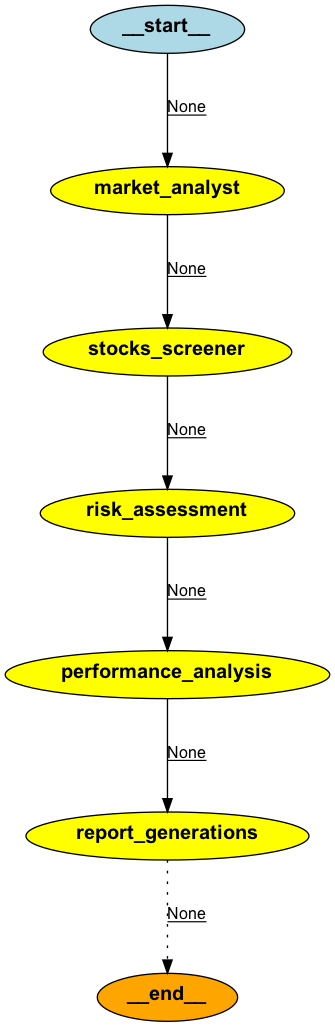

In [41]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [42]:
thread = {"configurable": {"thread_id":"1"}}
for s in graph.stream({
    'risk':"Low",
    "investment_amount": 200000,
    "investment_time": "5 Years",
    "specific_sectors" : ['Tech', 'Healthcare']
}, thread):
    print(s)

{'market_analyst': {'market_analysis': "After analysing the current market conditions using the Tavily API, I can provide you with the following insights:\n\n1. Tech Sector: The tech sector has been performing well, driven by the accelerated digital transformation and increasing adoption of cloud computing, artificial intelligence (AI), and machine learning (ML). Big tech companies like Apple, Microsoft, Alphabet, and Amazon are the key contributors to this growth. However, the sector is also facing regulatory risks and the potential impact of inflation on growth stocks is a concern. Therefore, it is advisable to diversify your investments in this sector.\n\n2. Healthcare Sector: The healthcare sector is experiencing substantial growth due to the ongoing pandemic. The biotechnology industry, in particular, is outperforming, driven by innovation in drug development and the commercial success of COVID-19 vaccines. Companies like Johnson & Johnson, Pfizer, Moderna, and Novartis are curren